# Predicting Future Avocado Prices 


### Dataset sourced from: **https://hassavocadoboard.com/** 

## Imports

In [1]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

## Exploratory Data Analysis

Our goal is to forcast the average avocado price for the next week. Let's start by reading the data

In [2]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
df.shape

(18249, 13)

In [4]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [5]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It appears that the data was collected from January 2015 to March 2018. Let us split the last 6 months into a testing set so that out model can run time series analysis later.

In [6]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [7]:
assert len(df_train) + len(df_test) == len(df)

Let us continue exploring the data. A good starting point would be examining how many time series are contained here. There could be multiple time series based on certain categorical features. 

In [107]:
df_train.sort_values(by="Date", ascending=False).groupby(["Date", "type"]).head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
14,2017-09-24,1.42,3627.18,56.82,95.31,0.00,3475.05,3475.05,0.00,0.00,organic,2017,Albany
14,2017-09-24,2.05,138458.82,34599.22,63107.77,1.57,40750.26,40700.41,49.85,0.00,organic,2017,California
14,2017-09-24,2.56,18912.30,507.34,5068.56,0.00,13336.40,4252.99,9083.41,0.00,organic,2017,Atlanta
14,2017-09-24,1.53,62464.93,2666.66,6252.03,94.49,53451.75,53451.75,0.00,0.00,organic,2017,BaltimoreWashington
14,2017-09-24,1.94,1125443.38,116338.61,237876.77,1182.85,769536.90,639021.62,130401.43,113.85,organic,2017,TotalUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,2015-01-04,1.35,9895.96,4634.70,1647.92,0.00,3613.34,3613.34,0.00,0.00,organic,2015,DallasFtWorth
51,2015-01-04,0.77,5144267.01,2745009.10,1755142.21,73432.89,570682.81,442217.85,128451.37,13.59,conventional,2015,SouthCentral
51,2015-01-04,1.41,2604.25,220.61,23.64,0.00,2360.00,2360.00,0.00,0.00,organic,2015,NewOrleansMobile
51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,organic,2015,HarrisburgScranton


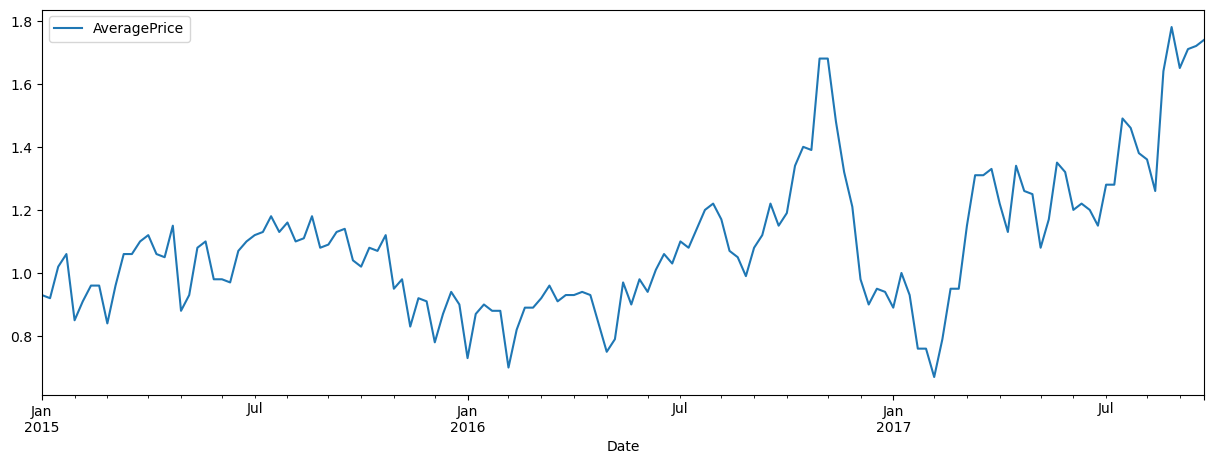

In [81]:
sorted_train = df_train.sort_values(by='Date').reset_index(drop=True)
plot_cali_train_c = sorted_train.loc[(sorted_train["region"] == "California") & (sorted_train["type"] == "conventional")]
plot_cali_train_c.plot(x="Date", y="AveragePrice", figsize=(15, 5));

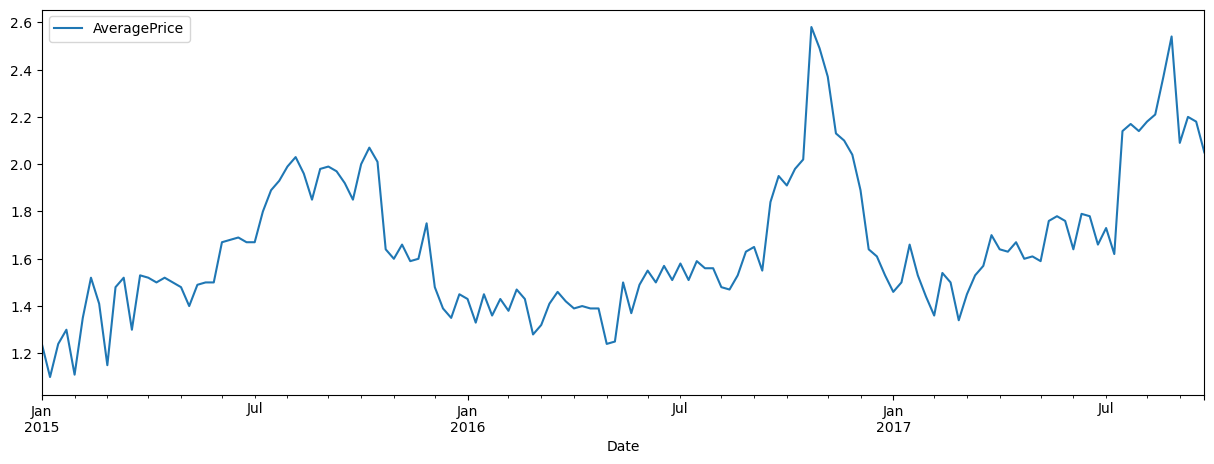

In [82]:
plot_cali_train_o = sorted_train.loc[(sorted_train["region"] == "California") & (sorted_train["type"] == "organic")]
plot_cali_train_o.plot(x="Date", y="AveragePrice", figsize=(15, 5));

It seems that there are different time series for each region and type of avocado. So, there are two time series for each region which are either "organic" or "conventional".

We can also examine how the intervals at which the data was collected

In [83]:
# df_copy = df_train.copy()
# df_copy['Date_Diff'] = df_copy['Date'].diff()
# unique_dates = df_copy['Date_Diff'].unique()
# unique_dates
# # unique_dates_count = df_copy['Date'].nunique()

# # print("Number of unique dates", unique_dates_count)
count = 0 
for name, group in df_train.groupby(['region']):
    print("%-30s %s" % (name, group["Date"].sort_values().diff().value_counts()))
    print('\n\n\n')
    count+=1
    if count == 8: 
        break

('Albany',)                    Date
0 days    143
7 days    142
Name: count, dtype: int64




('Atlanta',)                   Date
0 days    143
7 days    142
Name: count, dtype: int64




('BaltimoreWashington',)       Date
0 days    143
7 days    142
Name: count, dtype: int64




('Boise',)                     Date
0 days    143
7 days    142
Name: count, dtype: int64




('Boston',)                    Date
0 days    143
7 days    142
Name: count, dtype: int64




('BuffaloRochester',)          Date
0 days    143
7 days    142
Name: count, dtype: int64




('California',)                Date
0 days    143
7 days    142
Name: count, dtype: int64




('Charlotte',)                 Date
0 days    143
7 days    142
Name: count, dtype: int64






It seems that data was collected every 7 days for each region and type of avocado

Let's also check for any anomalies in the region 

In [111]:
df_regions = df_train['region'].nunique
df_regions

<bound method IndexOpsMixin.nunique of 0               Albany
1               Albany
2               Albany
3               Albany
4               Albany
            ...       
46    WestTexNewMexico
47    WestTexNewMexico
48    WestTexNewMexico
49    WestTexNewMexico
50    WestTexNewMexico
Name: region, Length: 15441, dtype: object>

There are overlapping regions such as "WestTexNewMexico" and "TotalUS" which overlap with individual states like "Texas" and "NewMexico". This may cause issues for more complicated data analysis but we will ignore them for our purposes

In [112]:
df_train

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,2017-01-29,1.30,17839.37,1486.34,4498.48,26.12,11828.43,11821.76,6.67,0.0,organic,2017,WestTexNewMexico
47,2017-01-22,1.21,16430.64,1413.93,2820.53,20.25,12175.93,12073.07,102.86,0.0,organic,2017,WestTexNewMexico
48,2017-01-15,1.19,17014.23,1203.87,2904.22,23.07,12883.07,12476.57,406.50,0.0,organic,2017,WestTexNewMexico
49,2017-01-08,1.18,14375.39,1327.98,2617.20,5.75,10424.46,10283.85,140.61,0.0,organic,2017,WestTexNewMexico


After a little bit of EDA, we can now begin the data processing. 
Below is a function adapted from [CPSC 330 Course Material: Lecture 19](https://github.com/UBC-CS/cpsc330-2023W2/blob/main/lectures/mathias/19_time-series.ipynb)

In [8]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

Using our newfound knowledge about how the data is structured, we will redo all of the data processing from previous steps \
We first sort our dataframe properly by region, type and Date:

In [9]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


Using the `create_lag_feature` function we adapted, we create a lagged feature of `AveragePrice` called `AveragePriceNextWeek`\
Additionally, notice that setting `clip=True` removes the rows where the target is missing after lagging the feature. 


In [10]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Finally, we split the data again

In [11]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

### Baseline Regression Model 

We will create a baseline regression model using `DummyRegressor` from sklearn to compare with our actual model \
To do this we will use the rudimentary approach of setting `AveragePriceNextWeek` to be the same as `AveragePrice` \
This is estentially predicting that all prices stay constant from week to week. 

Regression scores will be calculated using the $R^2$ metric

In [92]:
y_true = df_train["AveragePriceNextWeek"]
y_pred = df_train["AveragePrice"]

train_r2 = r2_score(y_true, y_pred)
print("Baseline Train R^2 Score:", train_r2)

Baseline Train R^2 Score: 0.8285800937261841


In [93]:
y_true_t = df_test["AveragePriceNextWeek"]
y_pred_t = df_test["AveragePrice"]

test_r2 = r2_score(y_true_t, y_pred_t)
print("Baseline Test R^2 Score:", test_r2)

Baseline Test R^2 Score: 0.7631780188583048


### Preprocessing and Regression Model

We first perform feature engineering by separating the date into year, month, and week to train a `RandomForestRegressor` model. \
Hyperparameter optimization will be performed using `RandomizedGridSearchCV` to optimize the model. 

#### Justification: 
We choose to separate the date since it is the most simple way to deal with a time series. \
A `RandomForestRegressor` is trained because it can capture the non-linear nature of the features with less work as opposed to `Ridge`. \
`RandomizedGridSearchCV` is used instead of `GridSearchCV` because it has generally higher performance

In [62]:
def get_week(date):
    day = date.day
    week = 1
    if day < 12 and day > 4:
        week = 2
    elif day < 19 and day >= 12: 
        week = 3
    elif day < 31 and day >= 19:
        week = 4
    return week 

In [82]:
# print(df_train.shape)
# df_lag = create_lag_feature(df_train, "AveragePrice", +2, ["region", "type"], "AveragePriceNextWeek2", clip=False)
# df_lag = create_lag_feature(df_lag, "AveragePrice", +3, ["region", "type"], "AveragePriceNextWeek3", clip=False)
# df_lag = create_lag_feature(df_lag, "AveragePrice", +4, ["region", "type"], "AveragePriceNextWeek4", clip=False)
# df_lag = create_lag_feature(df_lag, "AveragePrice", +5, ["region", "type"], "AveragePriceNextWeek5", clip=False)
X_df = df_train.assign(month = df_train['Date'].apply(lambda x: x.month),
                       week = df_train['Date'].apply(get_week))
# print(X_df.shape)

We also preprocess the data using `SimpleImputer` and `StandardScaler` for numeric features and `OneHotEncoder` for categorical features

In [103]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

numeric_feats = ['Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
drop_feats = ['Date', 'AveragePriceNextWeek']
categorical_feats = ['type', 'region', 'year', 'month', 'week']
pass_feats = ['AveragePrice']
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(), StandardScaler()), 
        numeric_feats,
    ),
    ("passthrough", pass_feats), 
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_feats,
    ),
    ("drop", drop_feats),
)
ct

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Total Volume', '4046', '4225', '4770',
                                  'Total Bags', 'Small Bags', 'Large Bags',
                                  'XLarge Bags']),
                                ('passthrough', 'passthrough',
                                 ['AveragePrice']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['type', 'region', 'year', 'month', 'week']),
                                ('drop', 'drop',
                                 ['Date', 'AveragePriceNextWeek'])])

Next we train the `RandomForestRegressor` and tune its hyperparameters using `RandomizedSearchCV` 

In [97]:
# X_ct = ct.fit_transform(X_df)
# y = df_train['AveragePrice'].to_numpy()
from sklearn.model_selection import RandomizedSearchCV
y = df_train['AveragePriceNextWeek']

pipe_rf = make_pipeline(ct, RandomForestRegressor(random_state=123))
# rf = RandomForestRegressor(n_estimators=33, random_state=0)

param_grid_rf = {
    "randomforestregressor__n_estimators": [15, 18, 20, 23],
    "randomforestregressor__max_depth": np.linspace(13,18,6).astype(int),
    "randomforestregressor__max_features": np.linspace(11, 16, 6).astype(int),
}

random_search_rf = RandomizedSearchCV(pipe_rf,                                    
                  param_distributions = param_grid_rf, 
                  n_iter=50, 
                  n_jobs=-1, 
                  return_train_score=True)

random_search_rf.fit(X_df, y)

# eval_on_features(X_ct, y, rf)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Total '
                                                                                'Volume',
                                                                                '4046',
                                                                                '4225',
                                                                                '4770',
                                                                                'Total '
                                                                                'Bags',
                                                                                'Small '
                                                                                'Bags',
                                                                                'Large '
                                                                                'Bags',
                                                                                'XLarge '
                                                                                'Bags']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['AveragePrice']),
                                                                              ('onehot...
                                                                               'drop',
                                                                               ['Date',
                                                                                'AveragePriceNextWeek'])])),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': array([13, 14, 15, 16, 17, 18]),
                                        'randomforestregressor__max_features': array([11, 12, 13, 14, 15, 16]),
                                        'randomforestregressor__n_estimators': [15,
                                                                                18,
                                                                                20,
                                                                                23]},
                   return_train_score=True)

In [98]:
relevant = ['mean_test_score',
            'param_randomforestregressor__n_estimators',
            'param_randomforestregressor__max_depth',
            'param_randomforestregressor__max_features',
            'mean_fit_time',
            'rank_test_score']

pd.DataFrame(random_search_rf.cv_results_)[relevant].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
mean_test_score,0.821389,0.82087,0.819962,0.817234,0.816955,0.816368,0.816047,0.81551,0.814945,0.81451,...,0.802874,0.802144,0.802082,0.802019,0.800946,0.79988,0.798159,0.797202,0.795426,0.789512
param_randomforestregressor__n_estimators,20,23,18,23,23,23,23,23,20,18,...,18,18,20,15,15,23,23,20,15,15
param_randomforestregressor__max_depth,16,16,16,14,15,17,18,13,15,17,...,14,18,13,14,13,16,17,17,17,14
param_randomforestregressor__max_features,16,16,16,14,14,14,14,16,14,15,...,12,11,12,12,12,11,11,11,11,11
mean_fit_time,4.928235,5.505388,4.167378,3.839284,4.490044,5.960936,6.139849,3.754474,3.9076,4.700951,...,2.514454,4.214505,2.545083,2.239282,1.769661,4.307125,4.777476,4.159573,3.104697,2.051996


There appear to be promising cross-validation test scores considering how many hyperparameters values were tried

In [34]:
# enc = OneHotEncoder()
# X_time_onehot = enc.fit_transform(X_time).toarray()
# eval_on_features(X_time_onehot, y, lr, feat_names = "hour of day OHE + day of week OHE + interaction feats")

In [35]:
# from sklearn.preprocessing import PolynomialFeatures

# poly_transformer = PolynomialFeatures(
#     interaction_only=True, include_bias=False
# )
# X_time_onehot_poly = poly_transformer.fit_transform(X_time_onehot)

In [36]:
# lr = Ridge()
# eval_on_features(X_time_onehot_poly, y, lr, feat_names = "hour of day OHE + day of week OHE + interaction feats")

In [100]:
X_df_test = df_test.assign(month = df_test['Date'].apply(lambda x: x.month),
                       week = df_test['Date'].apply(get_week))
y_t = df_test["AveragePriceNextWeek"]
pipe_final = make_pipeline(ct, 
            RandomForestRegressor(n_estimators = 20, max_depth = 16, max_features = 16, random_state=123))
pipe_final.fit(X_df, y)
final_score = pipe_final.score(X_df_test, y_t)
final_score

0.7800790688071346

Now we try doing additional feature engineering by making polynomial features of "week" and "month". Hopefully the model will recognize some sort of pattern in the new features and increase the score. 

Since the previous model produced promising results, the only change will be feature engineering

In [105]:
poly_feats = ['month', 'week']
categorical_feats2 = ['type', 'region', 'year']
ct2 = make_column_transformer(
    (
        make_pipeline(SimpleImputer(), StandardScaler()), 
        numeric_feats,
    ),
    ("passthrough", pass_feats), 
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore"), 
                      PolynomialFeatures(interaction_only=True, include_bias=False)),
        poly_feats,
    ),
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_feats2,
    ),
    ("drop", drop_feats),
)
ct2

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Total Volume', '4046', '4225', '4770',
                                  'Total Bags', 'Small Bags', 'Large Bags',
                                  'XLarge Bags']),
                                ('passthrough', 'passthrough',
                                 ['AveragePrice']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True))]),
                                 ['month', 'week']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['type', 'region', 'year']),
                                ('drop', 'drop',
                                 ['Date', 'AveragePriceNextWeek'])])

In [119]:
pipe_rf_2 = make_pipeline(ct2, RandomForestRegressor(random_state=123))

param_grid_rf_2 = {
    "randomforestregressor__n_estimators": [22, 23, 24, 25],
    "randomforestregressor__max_depth": np.linspace(34,63,6).astype(int),
    "randomforestregressor__max_features": np.linspace(29, 58, 6).astype(int),
}

random_search_rf_2 = RandomizedSearchCV(pipe_rf_2,                                    
                  param_distributions = param_grid_rf_2, 
                  n_iter=40, 
                  n_jobs=-1, 
                  return_train_score=True)

random_search_rf_2.fit(X_df, y)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Total '
                                                                                'Volume',
                                                                                '4046',
                                                                                '4225',
                                                                                '4770',
                                                                                'Total '
                                                                                'Bags',
                                                                                'Small '
                                                                                'Bags',
                                                                                'Large '
                                                                                'Bags',
                                                                                'XLarge '
                                                                                'Bags']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['AveragePrice']),
                                                                              ('pipe...
                                                                               'drop',
                                                                               ['Date',
                                                                                'AveragePriceNextWeek'])])),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=123))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': array([34, 39, 45, 51, 57, 63]),
                                        'randomforestregressor__max_features': array([29, 34, 40, 46, 52, 58]),
                                        'randomforestregressor__n_estimators': [22,
                                                                                23,
                                                                                24,
                                                                                25]},
                   return_train_score=True)

In [120]:
relevant = ['mean_test_score',
            'param_randomforestregressor__n_estimators',
            'param_randomforestregressor__max_depth',
            'param_randomforestregressor__max_features',
            'mean_fit_time',
            'rank_test_score']

pd.DataFrame(random_search_rf_2.cv_results_)[relevant].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,30,32,33,34,35,36,37,38,39,40
mean_test_score,0.835702,0.835701,0.835282,0.83494,0.834814,0.834771,0.834701,0.834643,0.834551,0.834522,...,0.816258,0.816113,0.816079,0.815986,0.815802,0.815778,0.815733,0.815438,0.814413,0.81337
param_randomforestregressor__n_estimators,24,22,24,24,23,22,24,22,23,25,...,24,25,23,25,23,25,24,23,22,22
param_randomforestregressor__max_depth,51,51,63,45,39,39,51,34,45,63,...,63,63,63,63,57,34,34,34,39,51
param_randomforestregressor__max_features,58,58,58,58,58,52,52,52,58,52,...,29,29,29,34,34,29,29,29,34,34
mean_fit_time,16.157432,15.162851,17.458048,17.249886,14.981811,13.602262,14.650575,14.442794,16.328703,16.060186,...,10.400806,10.987503,9.874281,12.395544,10.798579,10.730446,10.356732,9.295629,10.5119,10.722544


In [123]:
pipe_final_2 = make_pipeline(ct, 
            RandomForestRegressor(n_estimators = 24, max_depth = 45, max_features = 27, random_state=123))
pipe_final_2.fit(X_df, y)
final_score_2 = pipe_final_2.score(X_df_test, y_t)
final_score_2

0.7763169973550847

It seems that feature engineering isn't working as well as expected. We will return to the first model and try to improve its performance with more hyperparameter optimization 

In [124]:
param_grid_rf_3 = {
    "randomforestregressor__n_estimators": [22, 25, 27, 29],
    "randomforestregressor__max_depth": np.linspace(13,18,6).astype(int),
    "randomforestregressor__max_features": np.linspace(17, 23, 6).astype(int),
}

random_search_rf_3 = RandomizedSearchCV(pipe_rf,                                    
                  param_distributions = param_grid_rf_3, 
                  n_iter=50, 
                  n_jobs=-1, 
                  return_train_score=True)

random_search_rf_3.fit(X_df, y)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Total '
                                                                                'Volume',
                                                                                '4046',
                                                                                '4225',
                                                                                '4770',
                                                                                'Total '
                                                                                'Bags',
                                                                                'Small '
                                                                                'Bags',
                                                                                'Large '
                                                                                'Bags',
                                                                                'XLarge '
                                                                                'Bags']),
                                                                              ('passthrough',
                                                                               'passthrough',
                                                                               ['AveragePrice']),
                                                                              ('onehot...
                                                                               'drop',
                                                                               ['Date',
                                                                                'AveragePriceNextWeek'])])),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': array([13, 14, 15, 16, 17, 18]),
                                        'randomforestregressor__max_features': array([17, 18, 19, 20, 21, 23]),
                                        'randomforestregressor__n_estimators': [22,
                                                                                25,
                                                                                27,
                                                                                29]},
                   return_train_score=True)

In [125]:
relevant = ['mean_test_score',
            'param_randomforestregressor__n_estimators',
            'param_randomforestregressor__max_depth',
            'param_randomforestregressor__max_features',
            'mean_fit_time',
            'rank_test_score']

pd.DataFrame(random_search_rf_3.cv_results_)[relevant].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
mean_test_score,0.832592,0.832476,0.832337,0.832242,0.831879,0.831177,0.83089,0.830524,0.830379,0.83037,...,0.823827,0.823617,0.823089,0.822956,0.822815,0.82272,0.822616,0.821782,0.821104,0.820016
param_randomforestregressor__n_estimators,27,22,27,29,29,27,27,25,25,25,...,22,25,22,22,25,22,22,29,22,22
param_randomforestregressor__max_depth,18,15,13,17,15,14,14,18,14,14,...,14,13,16,16,14,17,18,13,13,14
param_randomforestregressor__max_features,23,23,23,23,21,23,21,20,23,21,...,19,19,19,17,17,17,18,18,17,17
mean_fit_time,11.09936,6.227773,5.795731,10.660077,8.056415,6.623692,6.326463,8.959137,6.47474,5.886329,...,5.155044,4.45032,6.212281,6.121805,4.800189,6.383442,7.340591,5.251399,3.739178,4.37234


In [126]:
pipe_final_3 = make_pipeline(ct, 
            RandomForestRegressor(n_estimators = 27, max_depth = 18, max_features = 23, random_state=123))
pipe_final_3.fit(X_df, y)
final_score_3 = pipe_final_3.score(X_df_test, y_t)
final_score_3

0.7716165129055444

It seems that the model is overfitting compared to the first iteration. \
The best score received for this model is stated below:

In [129]:
print("Best Score:", final_score)
print("Techniques: year-month-day separation, column transformer, RandomForestRegressor, RandomizedSearchCV")

Best Score: 0.7800790688071346
Techniques: year-month-day separation, column transformer, RandomForestRegressor, RandomizedSearchCV


## Conclusion

We successfully trained a time-series `RandomForestRegressor` model to determine the future average price of avocados across various regions with a 78% $R^2$ accuracy